In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

warnings.filterwarnings('ignore')

from datetime import date

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.layers import LSTM, Dense, Dropout, Layer
from tensorflow.keras.optimizers import Adam,RMSprop,AdamW
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Preprocessing Part

In [ ]:
start_date ='2024-02-01'
end_date = '2024-12-13'

In [ ]:
def creating_features(data):
  data = data.copy()
  data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]
  data = data.filter(regex='^Close')
  #data['Date'] = data.index.date
  #data['Date'] = pd.to_datetime(data['Date'])
  return data

In [ ]:
#Features_agglomorated
tickers = ['GC=F']

# Download historical data
features = yf.download(tickers, start= start_date, end=end_date, interval='1d')
#features = yf.download(tickers, end=end_date, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
final_data= creating_features(features).dropna()

In [ ]:
final_data.shape

(219, 1)

In [ ]:
final_data.head(7)

,Close_GC=F
Date,
2024-02-01,2053.000000
2024-02-02,2036.099976
2024-02-05,2025.699951
2024-02-06,2034.500000
2024-02-07,2035.199951
2024-02-08,2032.199951
2024-02-09,2023.300049


In [ ]:
final_data.tail()

,Close_GC=F
Date,
2024-12-06,2638.600098
2024-12-09,2664.899902
2024-12-10,2697.600098
2024-12-11,2733.800049
2024-12-12,2687.500000


In [ ]:
seq_length = 12

In [ ]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:(i + seq_len)])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

In [ ]:
def prepare_data(df, feature_column, seq_len=seq_length):
    data = df[feature_column].values.reshape(-1, 1)

    X, y = create_sequences(data, seq_len)

    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.2)

    X_train = X[:train_size]
    y_train = y[:train_size]

    X_val = X[train_size:train_size+val_size]
    y_val = y[train_size:train_size+val_size]

    X_test = X[train_size+val_size:]
    y_test = y[train_size+val_size:]

    scaler = MinMaxScaler()

    X_train_reshaped = X_train.reshape(-1, 1)
    scaler = scaler.fit(X_train_reshaped)

    X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    y_train_scaled = scaler.transform(y_train)
    y_val_scaled = scaler.transform(y_val)
    y_test_scaled = scaler.transform(y_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, scaler

In [ ]:
def forecast_future(model, last_sequence, scaler, horizon):

    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(horizon):

        next_pred = model.predict(current_sequence.reshape(1, -1, 1), verbose=0)
        future_predictions.append(next_pred[0, 0])

        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred

    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions)

    return future_predictions

In [ ]:
def lstm(seq_len):
  model1 = Sequential([
    Bidirectional(LSTM(100, activation='tanh', return_sequences=True, input_shape=(seq_len,1))),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(100, activation='tanh')),
    BatchNormalization(),
    Dropout(0.3),

    Dense(50, activation='relu'),
    Dense(1)
    ])
  model1.compile(optimizer='Adam',loss='huber', metrics=['mae'])
  return model1


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data(final_data, feature_column='Close_GC=F', seq_len=seq_length)

In [ ]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((144, 12, 1), (41, 12, 1), (22, 12, 1), (144, 1), (41, 1), (22, 1))

In [ ]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(factor=0.5, patience=5)


In [ ]:
model_lstm = lstm(seq_length)

In [ ]:
history_lstm = model_lstm.fit(X_train, y_train,
                  epochs=100,
                  batch_size=5,
                  validation_data=(X_val, y_val),
                  callbacks=[early_stopping, lr_reducer],
                  verbose=1)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 0.5344 - mae: 0.8921 - val_loss: 0.3741 - val_mae: 0.8614 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.3598 - mae: 0.7322 - val_loss: 0.3579 - val_mae: 0.8425 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.3063 - mae: 0.6504 - val_loss: 0.5497 - val_mae: 1.0489 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.2184 - mae: 0.5491 - val_loss: 0.4830 - val_mae: 0.9797 - learning_rate: 0.0010
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.2572 - mae: 0.5844 - val_loss: 0.4532 - val_mae: 0.9488 - learning_rate: 0.0010
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1553 - mae: 0.4173 - val_loss: 0.5946 - val_mae: 1.0941 - learning_rate: 0.0010
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1701 - mae: 0.4749 - val_loss: 0.2021 - val_mae: 0.6318 - learning_rate: 0.0010
Epoch

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Model Loss LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Predicting the price for a month in the horizon

horizon = 5

last_date = final_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=horizon, freq='B')
last_sequence = X_test[-1]

In [ ]:
#Prediction using lstm only
future_pred_lstm = forecast_future(model_lstm, last_sequence, scaler, horizon)

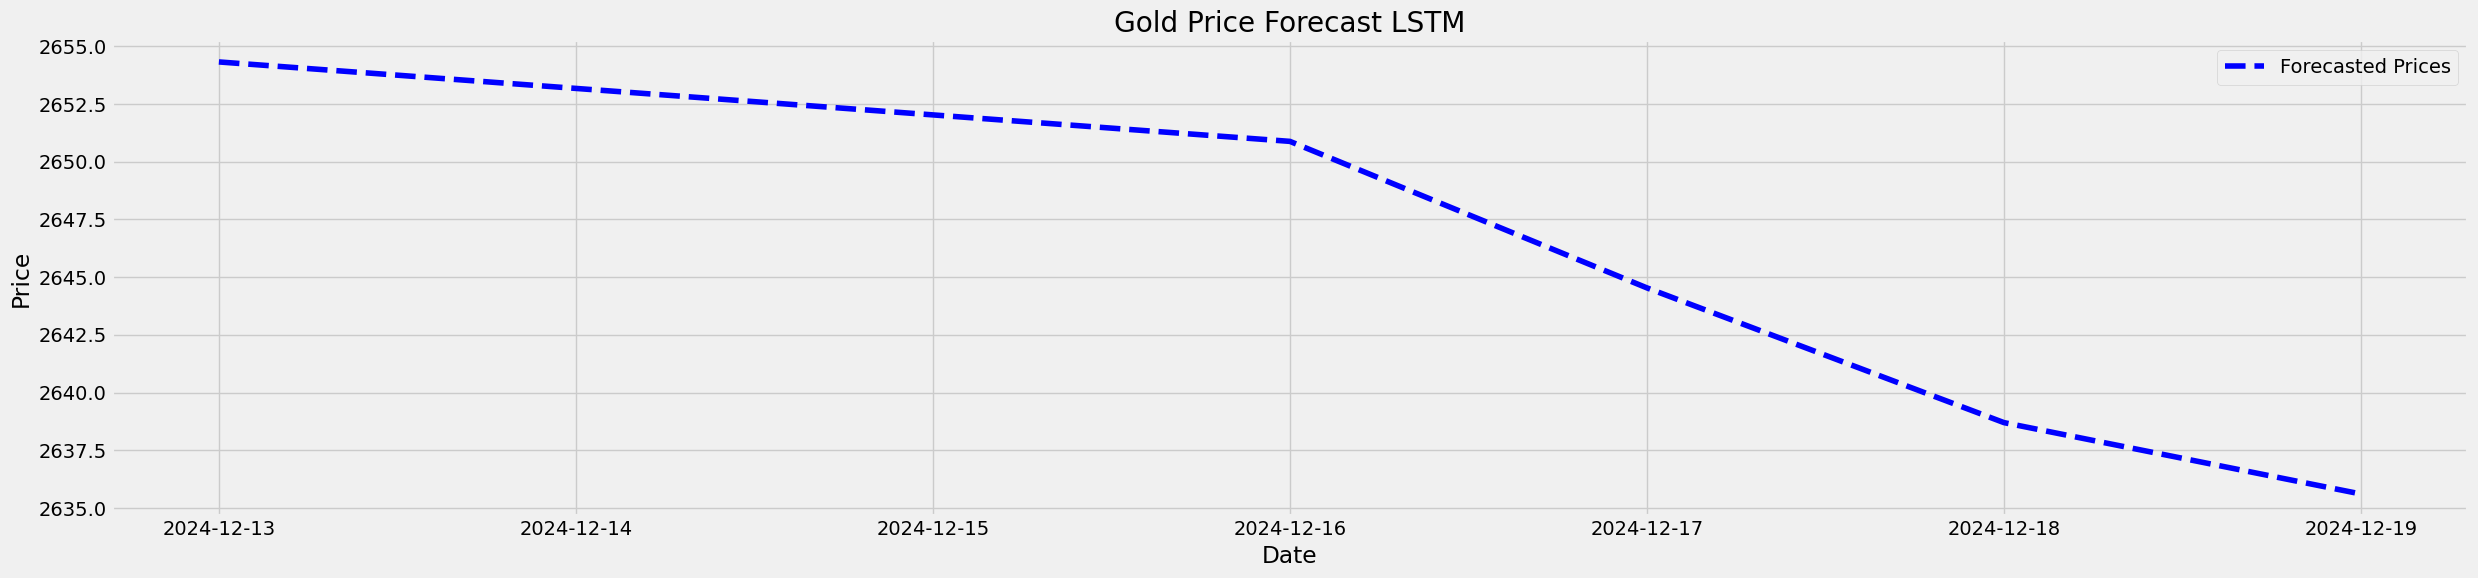

In [ ]:
plt.figure(figsize=(25, 6))

#plt.plot(final_data.index[-15:], final_data['Close_GC=F'].values[-15:], label='Historical Prices', color='green')


plt.plot(future_dates, future_pred_lstm, label='Forecasted Prices', linestyle='--', color='blue')
plt.title('Gold Price Forecast LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(future_dates)

DatetimeIndex(['2024-12-13', '2024-12-16', '2024-12-17', '2024-12-18',
               '2024-12-19'],
              dtype='datetime64[ns]', freq='B')


In [ ]:

real_future_data = yf.download(tickers, start= '2024-12-13', end='2024-12-20', interval='1d')


[*********************100%***********************]  1 of 1 completed


In [ ]:
cleaned = creating_features(real_future_data).head()

In [ ]:
rmse = np.sqrt(mean_squared_error(cleaned['Close_GC=F'], future_pred_lstm.flatten()))

mape = mean_absolute_percentage_error(cleaned['Close_GC=F'], future_pred_lstm.flatten()) * 100

In [28]:
print(f' For the LSTM only model, rmse value is {rmse} and mape value is {mape}')

 For the LSTM only model, rmse value is 19.455186200614826 and mape value is 0.3692246601650797
